# Overview 

Structure of project: 

**PART 1**
1. Introduction
2. Data preparation
    - 2.1 Load data
    - 2.2 Check for null and missing values
    - 2.3 Normalization
    - 2.4 Reshape
    - 2.5 Label encoding
    - 2.6 Split training and valdiation set
3. CNN
    - 3.1 Define the model
    - 3.2 Set the optimizer and annealer
    - 3.3 Data augmentation
4. Evaluate the model
    - 4.1 Training and validation curves
    - 4.2 Confusion matrix
5. Prediction and submition
    - 5.1 Predict and Submit results

Source for part 1: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
    
**PART 2**
1. Introduction 
    - describe data 
2. Prepare data 
    - format picture 
        - GaussianBlur/ medianblur 
    - Split letters
        - Contour detection 
        - Extract letter
        - align format 
3. Predict letter
    - apply model in part 1 
    - make (5x) prediction & assign probability 
    - indicate position in alphabet (letter) and concat 
    
    
Source for part 2: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

-----------------------------------
# Part 1: Model 

-----------------------------------


## Introduction 


This machine learning challenge exclusively deal with letter form the english alphabet. This means there are 26 classes (A-Z). 

The images of the EMIST dataset have intensity values are then scaled to [0, 255], resulting in the 28 × 28 pixel
gray-scale. This is important later when extracting the images from the 4 letter captacha. 

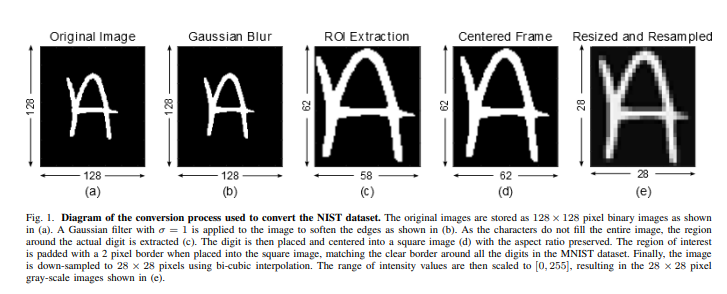

## Data Preparation 

Source: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

***Note: The code is used as guidance but is not directly copied. The workbook works with the famous MNIST dataset on which the EMNIST is dataset is based on. The format of the input data is identical so it is indeed quite useful***


Let's get started with the data preparation part...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

### 2.0 Load the data set 

In [2]:
## import dataset 
from os.path import join
from os import getcwd


## import data set 
path = join( getcwd(), 'data', 'training-dataset.npz' ) 

with np.load(path) as data: 
    
    img = data['x']
    lbl = data['y']

### 2.1 Check the data set

[[   1 4800]
 [   2 4800]
 [   3 4800]
 [   4 4800]
 [   5 4800]
 [   6 4800]
 [   7 4800]
 [   8 4800]
 [   9 4800]
 [  10 4800]
 [  11 4800]
 [  12 4800]
 [  13 4800]
 [  14 4800]
 [  15 4800]
 [  16 4800]
 [  17 4800]
 [  18 4800]
 [  19 4800]
 [  20 4800]
 [  21 4800]
 [  22 4800]
 [  23 4800]
 [  24 4800]
 [  25 4800]
 [  26 4800]]


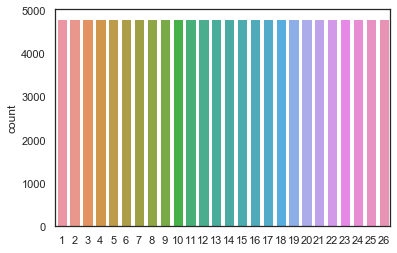

In [3]:
#countplot 
g = sns.countplot(lbl)

#unique value counts for array
(unique, counts) = np.unique(lbl, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print ( frequencies ) 

## ==> This tell us that we have for each variable an equal amount of training
##     data for each letter (4800 to be excat) and that we have (as stated in description) indeed 26 classes  

### 2.2 Check for null / missing values 

Let's see if we are being tripped up by Yash by inserting nan images 

A.: Doesn't look like it 

In [4]:
#check image data 
len( img[ np.isnan(img) == True ] ) 
#check label data 
len( lbl[ np.isnan(lbl) == True ] ) 


0

### 2.3 Normalisation 

Normalisation in general is good practice and allows faster convergence in CNN. Pixels reach from 0 to 255, hence division by the latter. Double checked with np.max(img) 

In [5]:
img = img/ 255.0 #float value to keep values consitent. 

### 2.4 Reshape 

The images are currently stored as 1D vectors of 784 values yet keras requires an extra dimension which corresponds to the channel denotating colour. As we are only using one channel (not all 3 of the RGB colour) it is displayed in Greyscale. Hence we need to reshape the data to 28x28x1 3D matrices.

In [6]:
img = img.reshape(-1,28,28,1)

### 2.5 Train/Val/Test Split 

Let's split the data into 0.64/0.14/0.2. We do not require stratified sampling we could see in step 2.1 that we have a balanced sample. For further explanation see: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

Now we simply need to accuratley split the data. Here is a helpful clarification for how the split works. https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

Why this split? To cite this towardsdatascience article and given that CCN have many hyperparameters a slightly larger split seems sensible. 

> "*Models with very few hyperparameters will be easy to validate and tune, so you can probably reduce the size of your validation set, but if your model has many hyperparameters, you would want to have a large validation set as well(although you should also consider cross validation).*"


**Note: we may want to reduce test set - not sure. Kaggle tutorial worked with Data set of "42 000 training images of balanced labels" with a 0.9 / 0.1 split**

In [7]:
#Train (0.8) / Test (0.2)
X_train, X_test, y_train, y_test= train_test_split(img, lbl, test_size=0.2, random_state=1)

#Test (0.60)/ val (0.25*0.8 = 0.2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

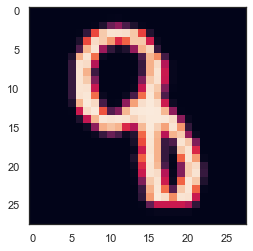

In [8]:
#Let's see if things worked out 
g = plt.imshow(X_train[0][:,:,0])

### 2.6 Label encoding 

Now we can encode the labels. We should have 26 lable corresponding to all the letters of the english alphabet.

In [9]:
##Set_up 
from sklearn.preprocessing import LabelBinarizer

## convert to make keras workable 
onehot = LabelBinarizer()
y_train_hot = onehot.fit_transform(y_train)
y_val_hot   = onehot.transform(y_val)
y_test_hot  = onehot.transform(y_test)

## 3. CNN

### 3.1 Define the model 

Here it may make sense to tune a few hyperparameter/ use Kristen/ Ruud code. I quite enjoyed this article on CCN - https://www.kdnuggets.com/2019/07/convolutional-neural-networks-python-tutorial-tensorflow-keras.html

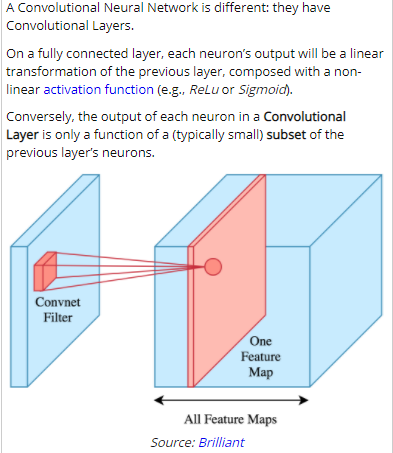

Relevant TensorFlow Keras documentation:
- Conv2D: "This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs." - Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

- MaxPool2D: "Downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis." - Source:https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

- Dropout: "The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting." - Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

In [10]:
# Set the CNN model 
# the CNN architechture used is In -> [[Conv2D->relu]*2 ->
# MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out


model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size = (5,5), # filter matrix
                 padding = 'Same', # preservs borders 
                 activation = 'relu', #activation function 
                 input_shape = (28, 28, 1))) #necessary input format
                
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) #Downsamples
model.add(Dropout(0.25)) #prevent overfitting 

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu')) #reduces filter size and increases filter
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) #turn into 1d output
model.add(Dense(256, activation = "relu")) # fully-connected (Dense) layers
model.add(Dropout(0.5))
model.add(Dense(26, activation = "softmax")) #net outputs distribution of probability of each class.

### 3.2 Set the optimizer and annealer

We now require a score function, a loss function and an optimisation algorithm.

loss function = 'categorical_crossentropy" - Loss function for multiclass classification problems - Source: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


Most importantly optimizer function, which is reposonsible for iteratively improving parameters. Uses RMSprop (with default values) but states that we can use SGD instead RMSprop is just more efficient. 

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Annealing the learning rate

"Another commonly employed technique, known as learning rate annealing, recommends starting with a relatively high learning rate and then gradually lowering the learning rate during training."

Source: https://www.jeremyjordan.me/nn-learning-rate/#:~:text=The%20most%20popular%20form%20of,set%20number%20of%20training%20epochs.

"In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can."


Source: https://cs231n.github.io/neural-networks-3/#annealing-the-learning-rate

In [12]:
#Avoid getting stuck in local max/min with annealer method 
## 


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [13]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [14]:
# ### currently do not understand how this code works 


# history = model.fit(X_train, y_train_hot, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, y_val_hot), verbose = 2)

## 3.3 Data augmentation (a.k.a. adding noise) 

"In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated..."


Here we can use ImageDataGenerator form Keras The data will be looped over (in batches) and random transformation to prevent overfitting. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=3,  # randomly rotate images in the range (degrees, 0 to 54) mot 90 as ME
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images - why bd, mw
        vertical_flip=False)  # randomly flip images - pd


datagen.fit(X_train)

In [16]:
history = model.fit_generator(datagen.flow(X_train,y_train_hot, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val_hot),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
870/870 - 471s - loss: 0.8847 - accuracy: 0.7278 - val_loss: 0.2313 - val_accuracy: 0.9216


## 4. Evaluation 

KeyError: 'acc'

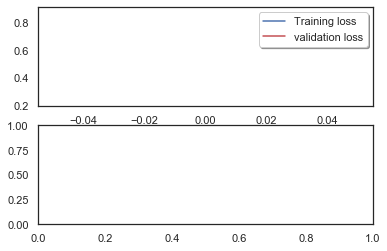

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


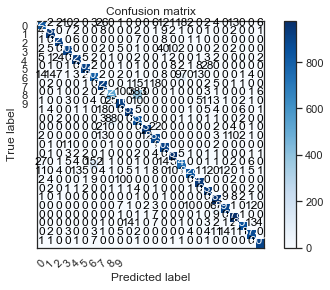

In [18]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val_hot ,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


Let's take a closer look at the error. 

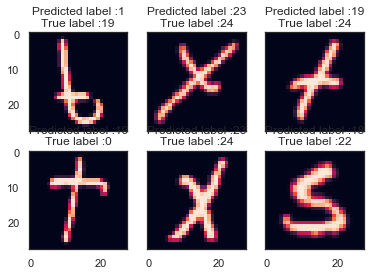

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [ ]:
# ## submit 
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

# submission.to_csv("cnn_mnist_datagen.csv",index=False

-----------------------------------
# Part 2: Captacha Solver 

-----------------------------------


## 1. Introduction

Let's check out the data we are dealing with. We know from ML Challenge document that that "the classifiers trained in the first task" must "identify a series of 4 letters in an image of size 30 × 140" and must create label predictions concatenating position of alphabet (*Note: not index position*) - e.g. image ‘22181224’ = ‘vrlx’. We must make create 5 predictions for each label. 


More on the test data set for ML Challenge sheet: 

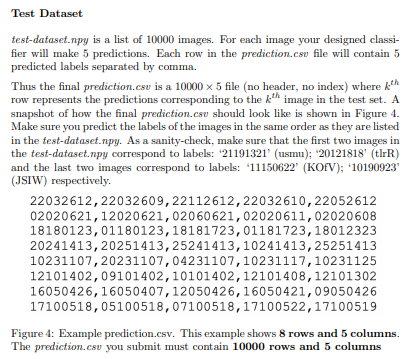

We are dealing here with grayscale Pixel data. I recommend to read chapter 3 in this book on image recognition: https://drive.google.com/file/d/1DjC2PPZq6E_4SI9gRm5-8ZWXGytyKymk/view?usp=sharing (Please don't share it further).

I decided to use opencv2 since other with similar task deployed it. OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. OpenCV was built to provide a common infrastructure for computer vision applications and to accelerate the use of machine perception in the commercial products. (https://opencv.org/) 


In addtition i made use of the PIL library (https://pillow.readthedocs.io/en/stable/) again a apparently commonly library. I made use as the format of the input file changed. (Huggggeee headache finding out how to convert into a predicable format for keras). 

In [20]:
import numpy as np 
from os.path import join
from os import getcwd
path = join( getcwd(), 'data', 'test-dataset.npy' ) 
test_ll = np.load(path) # test_ll = test_labelless

### Sanity check 

In [171]:
# Sanity check 1
from PIL import Image

im0 = Image.fromarray(np.uint8(test_ll[0]))
im0 # usmu 

In [22]:
# Sanity check 2
im1 = Image.fromarray(np.uint8(test_ll[1]))
im1 # (tlrR)

In [23]:
# Sanity check 3
im_m1 = Image.fromarray(np.uint8(test_ll[-1]))
im_m1 # (JSIW)

In [24]:
# Sanity check 4
im_m2 = Image.fromarray(np.uint8(test_ll[-2]))
im_m2 #  (KOfV)

==> **Looking good** 

In [25]:
## dataset 
print( test_ll.shape) # looks good 

## Some other characteristics 
print( test_ll[0].shape ) 


(10000, 30, 140)
(30, 140)


## 2. Prepare data

This section consit out of the following:

- Data preparation
- format picture
    - GaussianBlur/ medianblur
- Split letters
    - Contour detection
    - Extract letter
    - align format (28x28) 
    
 

### 2.1 Data preparation

We cannot repeat the step done in the kaggle tutorial for data preparation in the same order. We require to reshape the data (which essentiall was just adding an additional channel ("colour channel") to the picture data with the reshape function. 

We cannot normalise just yet because we have to apply cv2 transformation, which require us to have pixel data ranging from 0 to 255 and not as in the normalised instance from 0 to 1. 

In [26]:
# We can't repeat the step from the kaggle tutorial
# ## Normalisation - we meed to save for later before we make the predictions of the letters 
# tll = test_ll/255.0 

## reshape images to 3dimension with last one just being grayscale 1 not 3 
tll = test_ll.reshape(-1,30,140,1)
print(tll.shape)

(10000, 30, 140, 1)


### 2.2 Formating the picture

#### 2.2.1 MedianBlur (removing Salt & Pepper) 

If we look at the picture more accuratley we can see that we have impulse noise a.k.a. “salt and pepper” noise, essentially the white dots. They do not help classification so lets get rid of them. 

A method of removing them is a median filter. "The function cv2.medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value. This is highly effective in removing salt-and-pepper noise."

As we are working with black and white data now we can also apply GaussianBlur (with colour data GaussianBlur can create new colour originally not in the pic). 

Source: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [27]:
## this is the original 
import cv2
cv2.imshow('Original', np.uint8(tll[0]) )  
cv2.waitKey(0)

-1

In [118]:
# Let make a quick test image to run through the process once 
img_test =  np.uint8(tll[0]) 

In [123]:
# lets see what happens to image 

#Either just median blur 

#blur = cv2.medianBlur(img_test , 3).copy() # need to be uneven ## pixel window of 3 = best results
#blur = cv2.GaussianBlur(np.uint8( tll[0] ), (7,7),0) # I also applied GaussianBlur but that seems less effective


#OR
blur = cv2.bilateralFilter(img_test,3,3000,3000)
cv2.imshow('blur',blur)
cv2.waitKey(0)


blur2 = cv2.medianBlur(blur, 5)
cv2.imshow('blur2',blur)
cv2.waitKey(0)

-1

#### 2.2.2 Thresholding 

Our image after the median blur looks a little gloomy. We can apply thresholding to imporve the contour of the images/ contrast. Thresholding works by assigning a pixel value in a either or fashion depending on the threshold value.

> "*If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black). The function used is cv2.threshold. First argument is the source image, which should be a grayscale image. Second argument is the threshold value which is used to classify the pixel values. Third argument is the maxVal which represents the value to be given if pixel value is more than (sometimes less than) the threshold value.*"

Source: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

In [125]:
ret, thresh = cv2.threshold(blur2,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) 

cv2.imshow('threshold',thresh)
cv2.waitKey(0)

-1

In [ ]:
#SKELTON 

NOTE: I think it could be useful to apply the sharping transformation to our training data to prime the algorithm to better recognise these wonky letter shapes. 

### 2.3 Letter extraction 

Now that our images are sharp. We can try to extract the letters by checking their contours. 





#### 2.3.1 Contour detection

Check out this brief tutorial: https://docs.opencv.org/master/d5/daa/tutorial_js_contours_begin.html


But essentially we try to identify the contour with: 
> cv.findContours (image, contours, hierarchy, mode, method, offset = new cv.Point(0, 0))

And then draw the cotour on the original image with: 
> cv.drawContours (image, contours, contourIdx, color, thickness = 1, lineType = cv.LINE_8, hierarchy = new cv.Mat(), maxLevel = INT_MAX, offset = new cv.Point(0, 0))

In [126]:
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

## command drawCountours paints on the image thus I am making a copy of the img_test
canvas = thresh.copy()

cv2.drawContours( canvas,contours,-1,thickness=2, color=127) #Green = (0,255,0) but since its not a 
                                                             #coloured image no point thus choice 127
cv2.imshow('draw contours',canvas)
cv2.waitKey(0)


-1

#### 2.3.2 Extracting the letter 

if we check the len(contours), we notice that it is only 3 instead of 4 contours, which we would expect given that e know that each captchas consist out of 4 letters. This is due to an overlap in letters, which you can see once we draw the contour on the image

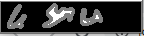

The solution of this problem can be found in this medium post and the crucial idea is that we detect overlaps if height and width do not match. I adapted the idea because I think it smarter do the following: 

- If len(contours) != 4, then look for contour with longest width and divide by 2

In [127]:
## split rectangles and save order 
d_rectangle_contour = {}

if len(contours) != 4: 
    
    for i in range(len(contours)):
        
        d_rectangle_contour[i] = cv2.boundingRect(contours[i])
        

#sort dictionary with entry with longest with
longest_width = sorted(d_rectangle_contour.items(), key=lambda x:x[1][2])[-1]


#create new dic with order and new rectangle frames
new_contours = {}
counter = 0 

for contour in d_rectangle_contour.values(): 
    
    #separate letters 
    if contour == longest_width[1]: 
        
        #setup
        x, y, w, h = contour 
        
        #first letter 
        r1 = x, y, int(w/2), h 
        new_contours[counter] = r1
        counter +=1 
        
        #second letter 
        r2 = int(x + w/2), y, int(w/2), h
        new_contours[counter] = r2     
        counter +=1 
    
    
    else: 
        new_contours[counter]= contour
        counter +=1 
            
new_contours

{0: (80, 7, 21, 16), 1: (7, 3, 18, 23), 2: (42, 2, 15, 23), 3: (57, 2, 15, 23)}

In [128]:
# Let's look at a single letter
x, y, w, h = new_contours[3]

# Extract the letter from the original image with a 2-pixel margin around the edge
letter_image = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

cv2.imshow('Letter_image', letter_image)
cv2.waitKey(0)

-1

#### 2.3.3 Resize the extracted letter

We got the letter but now we have to adjust it so that we can use it for our model. The current shape of this particular input is letter_image.shape >>> (20, 25). We need 28 x 28 like the input. In addition this has to happen flexibly. 

Note: This may be an area where issues appear but this seemed to be working fine. 

In [35]:
l_I2828 = cv2.resize(letter_image, (28, 28))

cv2.imshow('test', l_I2828)
cv2.waitKey(0)

-1

## 3 Prediction of a single letter 

Now we should be ready to make a prediction. Let's see....

### 3.1 Make fit for model



Normalisation & Reshape

In [161]:
K = l_I2828/255.0  # Normalisation 
K = K.reshape(-1,28,28,1)

print(K.shape)

(1, 28, 28, 1)


### 3.2 Prediction

In [37]:
pred = model.predict(K)
print(onehot.inverse_transform(pred))

### Hurray we got an m (which is correct)

[14]


# 4. Putting it all together

We now have everything necessary for putting it all together. Let's see if we can make it work... 

## 4.1 Supporting functions


In [131]:
##>>>>> CONDITION: CHECK if we found 4 letter     
def find_contour(dic): #dictionary with rectangle contour & index as key
    
    #Step 2: sort dictionary with entry with longest width
        ###NOTE: Assumption - Overlapping letters are of longest width 
    longest_width = sorted(dic.values(), key=lambda x:x[2])[-1] #longest one last 

    #Step 3: Create new contours 
    new_contours = {}
    counter = 0 

    for ind in range( len(dic) ): 

        #separate letters 
        if dic[ind] == longest_width: 

            #setup
            x, y, w, h = dic[ind] 

            #first letter 
            r1 = x, y, int(w/2), h 
            new_contours[counter] = r1
            counter +=1 

            #second letter 
            r2 = int(x + w/2), y, int(w/2), h
            new_contours[counter] = r2     
            counter +=1 
            

        else: 
            new_contours[counter]= dic[ind]
            counter +=1   
                   
    return new_contours # contours_found (for testing > shows change)

########TEST########
# x, y = find_contour( contours ) # contours_found, new_contours
# print(x, y)
# test = {0:(15,10,2,3), 1:(24,12,4,2)}
# find_contour( test )

In [132]:
# 100 % more elgant/ efficent way of doing it 


def unwanted(dic): #List of array of contours// assumes contour more than 4 
        
    # list of array by how many too long 
    no_excess = len(dic) - 4
    
    #list showing array and size of respective array
    l = []
    for contour in dic.values():
        
        #setup
        x, y, w, h = contour

        l.append( (contour, (w*h)) )
        

    #create new list with excess array
    excess =  sorted(l, key=lambda x:x[-1])[:no_excess]
    re_list = []
    
    for item in excess:
        
        re_list.append(item[0])

    #Step 3: Create new contours 
    new_contours = {}
    counter = 0 

    for val in dic.values():
        
        if val in re_list: 
            
            continue 
            
        else: 
            new_contours[counter] = val
            counter +=1
            
    return new_contours

# #unwanted(x)
# test = {0:(15,10,2,3), 1:(24,12,4,2), 2:(90,60,2,3), 3:(300,2,32,2), 4:(49,10,2,3), 5:(67,12,3,2)}
# unwanted(test)

In [133]:
### find 4 contour if we do not have 4 contours 
def find_4contours(contours_found): # dic with index keys 
    
    if len( contours_found ) < 4:
            
            new_contours = find_contour(contours_found) # here recursion would be good 
            
    else:
            
            new_contours = unwanted(contours_found) #removes excess array based on size
            
    return new_contours

In [134]:
### check if we have 4 contours in recursive fashion 
def check(contours_found):
    
    if len(contours_found) == 4: 
        
        return contours_found
    
    else: 
        return check(find_4contours(contours_found))
    

##Too Long 
# test = {0:(15,10,2,3), 1:(24,12,4,2), 2:(90,60,2,3), 3:(300,2,32,2), 4:(49,10,2,3), 5:(67,12,3,2)}
# check(test)

##Too short 
# test = {0:(15,10,2,3), 1:(24,12,4,2)}
# check(test)

## =4 
# test = {0:(15,10,2,3), 1:(24,12,4,2), 2:(90,60,2,3), 3:(300,2,32,2), 4:(49,10,2,3)}
# check(test)

{0: (24, 12, 4, 2), 1: (90, 60, 2, 3), 2: (300, 2, 32, 2), 3: (49, 10, 2, 3)}

## 4.2 Code Execution all

In [231]:
import numpy as np 
from os.path import join
from os import getcwd
import imutils
import cv2
from helpers import resize_to_fit

#load dataset 
path = join( getcwd(), 'data', 'test-dataset.npy' ) 
captchas = np.load(path).astype('uint8') # test_ll = test_labelless


#iterate through case by case: 
final_pred = []
css = []

for exp, captcha in enumerate (captchas): 
    
    #------format captcha image-----#
    
    ##add extra padding around the image
    pad = cv2.copyMakeBorder(captcha, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    
    ## blur 
    blur = cv2.medianBlur(pad , 3)
    
    ##thresholding 
    _, thresh = cv2.threshold(blur,127,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) #127 middle between white/black
    
    
    #------contour extraction-----#
   
    ##detect contours of all images 
    contours, hierachy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    #print (contours, f"hierachy: {hierachy}")
    #------contour filtration-----#
    
    ##contours smaller than 30 pixels excluded
            ##NOTE - replacing pixel with black may lead to imporvement
    
    contours_letters = []
    
    for contour in contours:
        
        css.append(contour.size)

        if contour.size > 30: # check whats the best size 
            
            contours_letters.append(contour)
            
            
    #------letter extraction-----#  
    
        #Prep: Build dic with contours and index as key
        
    contours_extracted = [] #stores contours found: rectangle
                        #e.g. [(103, 9, 20, 17), ...]
    
    for i in range( len(contours_letters) ):
        
        contours_extracted.append(cv2.boundingRect(contours_letters[i]))
        
        
    #------sort contours-----# 
     ## sorted in accordance with x position
    sort_x = sorted(contours_extracted, key=lambda x: x[0])
    
    ##index key position
    contours_found = {}
    
    for ind, contour in enumerate( sort_x ):
        
        contours_found[ind] = contour
        
    #--contour rectangle adjust--#
    
        #Main part: Finding relevant 4 contours if 
        #we do not have more or less than 4 contours
    
    new_contours = check( contours_found ) #this works 
        
    #-------prediction-------
    
        #take dictionary with index as key in form {0: (103, 9, 20, 17), ...}
    
    captcha = ""
    
    for key in new_contours.keys():
        
        x, y, w, h = new_contours[key]
        
        # Extract the letter from the original image with a 2-pixel margin around the edge
        #letter_image = pad[y - 2:y + h + 2, x - 2:x + w + 2]
        letter_image = pad[y:y + h, x:x + w]
        
        #resize
        #letter_image = resize_to_fit(letter_image, 28, 28)
        #l_I2828 = imutils.resize(letter_image, width=28, height=28)
        l_I2828 = cv2.resize(letter_image, (28, 28)) #here is the error 
        
        #Normalisation/ reshape
        K = l_I2828/255.0  # Normalisation 
        K = K.reshape(-1,28,28,1)
        
        #prediction
        pred = model.predict(K)
        
        #append list 
        letter = onehot.inverse_transform(pred)[0]
        captcha += str( letter ) 
    
    final_pred.append(int(captcha))
    
    
#Missing: 
#put prediction is right format 
#make 5 different predicitions 
    ### here it may be a good idea to base that on different formating 
    ###of the input image (GaussianBlur, different threshold)
    
#ensure that there are always extactly four contours 
    ## we managed to get never more than 4 
    ## missing we can get less than 3 --> recursion 
            

KeyboardInterrupt: 

In [233]:
im0 = Image.fromarray(np.uint8(test_ll[1]))
im0 # usmu 

In [232]:
final_pred[1]

20252318

In [ ]:
### Improvement
- [4]Skeltoon of multiscv2 libary 
- [1]Train with same blur transformation of images as in test
- [2]Play around which contours are captured and/or pixel them out 
- [3]Train different algos
- [5]Blur Noise filer (not so promising)
- 5 model for 5 predicitions? 
- [Check whats the best size to eliminate contour]
- [simplify make neather ]

